# Import neccessary functions

In [38]:
import os
import glob
import re                # ← Add this line
import numpy as np
import nibabel as nib
from nilearn import datasets
from nilearn.image import resample_to_img
from nilearn.image import load_img
from nilearn.masking import apply_mask

## Double check data resolution

In [39]:
# Load the BOLD cleaned image
bold_img = nib.load('/Volumes/Passport/fmriprep/derivatives/pieMan_cleaned/sub-002/func/sub-002_task-pieman_run-1_cleaned_desc-masked_bold.nii.gz')

# Print voxel size (spatial resolution) and TR (temporal resolution)
zooms = bold_img.header.get_zooms()
print(f"Voxel size (mm): {zooms[:3]}")
print(f"TR (s): {zooms[3]}")
print(f"Shape {bold_img.shape}")

Voxel size (mm): (3.0, 3.0, 4.0)
TR (s): 1.0
Shape (65, 77, 49, 160)


## Set user parameters (Will need to adjust code later to exclude certain subjects and runs like we did in cleaning code)

In [40]:
# ─── USER PARAMETERS ────────────────────────────────────────────────────────
subjects = ['sub-002']  # list of participants you want to run
base_dir = '/Volumes/Passport/fmriprep/derivatives'     # directory where "derivatives/pieMan_cleaned" lives
task_label = 'pieman'

# Output directory for RDMs
rdm_out_dir = os.path.join(base_dir, "RDMs")
os.makedirs(rdm_out_dir, exist_ok=True)

In [41]:
# ─── FETCH SCHAEFER ATLAS (ONCE) ─────────────────────────────────────────────

# Schaefer parcel/atlas parameters
parcel_id = 1                       # parcel number from Schaefer parcellation
n_rois = 200
yeo_networks = 17
resolution_mm = 2                   # resolution of your Schaefer atlas (double check!)

schaefer    = datasets.fetch_atlas_schaefer_2018(
                 n_rois=n_rois,
                 yeo_networks=yeo_networks,
                 resolution_mm=resolution_mm
             )
atlas_img   = nib.load(schaefer['maps'])  # default 2mm MNI - but our images 3x3x4 (Pieman and others) OR 2.5^3 (ie., Black and Forgot)

atlas_resampled = resample_to_img(atlas_img, bold_img, interpolation='nearest')
atlas_data     = atlas_resampled.get_fdata()



# Change Schaeffer Labels so 0 is whole brain and 1 corresponds to 1st ROI
labels = schaefer['labels']
# change to string and remove excess
labels = [l.replace(b'17Networks_', b'').decode('utf-8') for l in labels]
# Prepend background label
labels = np.insert(labels, 0, "Background")

In [42]:
print(labels.shape)
np.unique(atlas_data).shape

(201,)


(201,)

In [43]:
atlas_data.max()


200.0

In [44]:
labels[0]

img = load_img(schaefer['maps'])
img.to_filename(f"~/Downloads/schaefer_yeo17_200Parcels_2mm.nii.gz")

img_data = img.get_fdata()
img_mask = img_data == 0
# save as nifti file:
img_mask = nib.Nifti1Image(img_mask.astype(np.uint8), img.affine, img.header)
img_mask.to_filename(f"~/Downloads/schaefer_yeo17_200Parcels_2mm_mask.nii.gz")


In [45]:
# ─── FUNCTION TO COMPUTE RDM ─────────────────────────────────────────────────
def compute_rdm_for_subject(sub):
    print(f"\nProcessing {sub}...")
    
    func_dir   = os.path.join(base_dir, "pieMan_cleaned", sub, "func")
    bold_files = sorted(glob.glob(
        os.path.join(func_dir, f"{sub}_task-{task_label}*_cleaned_desc-masked_bold.nii.gz")
    ))
    if not bold_files:
        print(f"  ⚠️ No cleaned BOLD files for {sub}, skipping.")
        return

    for bf in bold_files:
        run_m = re.search(r"_run-(\d+)_", os.path.basename(bf))
        run   = run_m.group(1) if run_m else "1"
        run_tag = f"_run-{run}"
        
        print(f"  Found file: {os.path.basename(bf)} → {run_tag}")
        
        # Load bold img
        bold_img       = nib.load(bf)
        bold_data      = bold_img.get_fdata()  # shape (X, Y, Z, 160)
        
        # Extract parcel voxels × time
        print(f"Extracting parcel {parcel_id} ({labels[parcel_id]}) timeseries...")
        parcel_mask        = (atlas_data == parcel_id)
        parcel_timeseries  = bold_data[parcel_mask, :]  # (n_voxels, 160)

        if parcel_timeseries.size == 0:
            print(f"    ⚠️ No voxels in parcel {parcel_id}, skipping run.")
            continue
        
        print(f"    Voxels: {parcel_timeseries.shape[0]}, TRs: {parcel_timeseries.shape[1]}")
        
        # Vectorized Pearson-correlation RDM
        # Corr matrix: shape (160,160)
        corr_mat = np.corrcoef(parcel_timeseries.T)
        print(f"    Corr matrix shape: {corr_mat.shape}")
        assert corr_mat.shape == (160,160), f"Corr matrix is not the right shape: {corr_mat.shape}"
        
        # Convert to dissimilarity
        RDM = 1 - corr_mat
        
        # Save
        out_fname = f"{sub}{run_tag}_{task_label}_parcel-{parcel_id}_RDM.npy"
        out_path  = os.path.join(rdm_out_dir, out_fname)
        np.save(out_path, RDM)
        print(f"    ✅ Saved RDM to {out_path}")

In [46]:
# ─── RUN FOR ALL SUBJECTS ────────────────────────────────────────────────────
for sub in subjects:
    compute_rdm_for_subject(sub)

print("\nALL DONE!")


Processing sub-002...
  Found file: sub-002_task-pieman_run-1_cleaned_desc-masked_bold.nii.gz → _run-1
Extracting parcel 1 (LH_VisCent_ExStr_1) timeseries...
    Voxels: 243, TRs: 160
    Corr matrix shape: (160, 160)
    ✅ Saved RDM to /Volumes/Passport/fmriprep/derivatives/RDMs/sub-002_run-1_pieman_parcel-1_RDM.npy

ALL DONE!


# Visualize (optional)

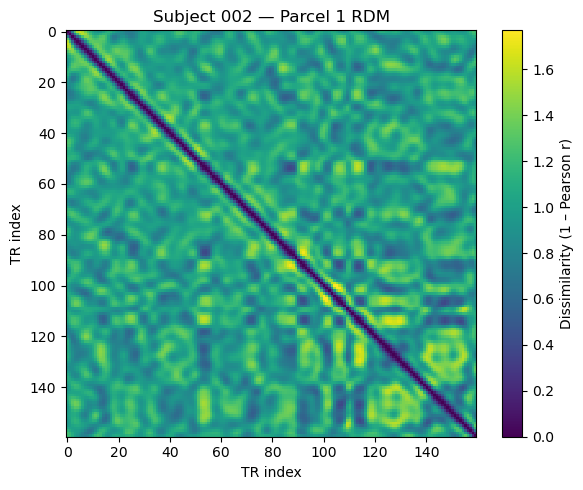

In [47]:
import matplotlib.pyplot as plt

# Path to your saved RDM
rdm_path = '/Volumes/Passport/fmriprep/derivatives/RDMs/sub-002_run-1_parcel-1_RDM.npy'

# 1) Load the RDM
RDM = np.load(rdm_path)  # shape (160, 160)

# 2) Plot as a heatmap
plt.figure(figsize=(6, 5))
plt.imshow(RDM, interpolation='nearest', aspect='auto')
plt.title('Subject 002 — Parcel 1 RDM')
plt.xlabel('TR index')
plt.ylabel('TR index')
cbar = plt.colorbar()
cbar.set_label('Dissimilarity (1 – Pearson r)')
plt.tight_layout()
plt.show()